In [1]:
%matplotlib inline

import abc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.distributions as tfd

In [2]:
def initialize_samples(n_samples, n_dims):
  samples_shape = [n_samples, n_dims]
  initializer = tf.initializers.random_uniform(minval=-1, maxval=1)
  samples = tf.get_variable(
      'samples', shape=samples_shape,
      dtype='float32', initializer=initializer)
  return samples

In [3]:
'''
class BaseKernel(abc.ABC):
    
    def __init__(self, xs, ys):
      self.xs = xs
      self.ys = ys
    
    @property
    @abc.abstractmethod
    def pairwise(self):
        pass
    
    @property
    @abc.abstractmethod
    def grad_pairwise(self):
        pass

class RBFKernel(BaseKernel):

  def __init__(self, xs, ys h=None):
    super().__init__(xs, ys)
    
    # --- Construct `self._kxy` and `self._grad_kxy_by_x` ---
    m, n = xs.get_shape().as_list()
    # :math:`x_i^{\alpha} - y_j^{\alpha}`, shape `[m, m, n]`
    deltas = (tf.expand_dims(xs, axis=1)
              - tf.expand_dims(ys, axis=0))
    # :math: \sum_{\alpha} (x_i^{\alpha} - y_j^{\alpha})^2,
    # shape `[m, m]`
    distances = tf.reduce_sum(tf.square(deltas), axis=-1)
    if h is None:
      h = get_median(distances) / tf.log(float(m))
    # :math:`k(x_i, y_j)`, shape `[m, m]`
    self._kxy = tf.exp(-1/h * distances)
    # :math:`\nabla_{\alpha} k(x_i, y_j)`, shape `[m, m, n]
    self._grad_kxy_by_x = tf.multiply(
        -1 / h * deltas,
        tf.expand_dims(self._kxy, axis=-1)
    )

  @property
  def pairwise(self):
    return self._kxy

  @property
  def grad_pairwise(self):
    return self._grad_kxy_by_x
'''

'\nclass BaseKernel(abc.ABC):\n    \n    def __init__(self, xs, ys):\n      self.xs = xs\n      self.ys = ys\n    \n    @property\n    @abc.abstractmethod\n    def pairwise(self):\n        pass\n    \n    @property\n    @abc.abstractmethod\n    def grad_pairwise(self):\n        pass\n\nclass RBFKernel(BaseKernel):\n\n  def __init__(self, xs, ys h=None):\n    super().__init__(xs, ys)\n    \n    # --- Construct `self._kxy` and `self._grad_kxy_by_x` ---\n    m, n = xs.get_shape().as_list()\n    # :math:`x_i^{\x07lpha} - y_j^{\x07lpha}`, shape `[m, m, n]`\n    deltas = (tf.expand_dims(xs, axis=1)\n              - tf.expand_dims(ys, axis=0))\n    # :math: \\sum_{\x07lpha} (x_i^{\x07lpha} - y_j^{\x07lpha})^2,\n    # shape `[m, m]`\n    distances = tf.reduce_sum(tf.square(deltas), axis=-1)\n    if h is None:\n      h = get_median(distances) / tf.log(float(m))\n    # :math:`k(x_i, y_j)`, shape `[m, m]`\n    self._kxy = tf.exp(-1/h * distances)\n    # :math:`\nabla_{\x07lpha} k(x_i, y_j)`, shap

In [4]:
def rbf_kernel(xs, ys, name=None):
  """Returns :math:`k(x_i, y_j)` and :math:`\nabla k(x_i, y_j)`,
  for :math:`\forall i, j = 1, \ldots m` for some :math:`m`, and
  :math:`x_i, y_j \in \mathbb{R}^n`, where the :math:`k(\cdot, \cdot)`
  is the RBF kernel.
  
  Args:
    xs: Tensor of the shape `[m, n]` for some `m` and `n`.
    ys: Tensor of the same shape as `xs`.
  Returns:
    Two tensors. The first is of shape `[m, m]`, the second is of
    `[n, m, m]`.
  """
  with tf.name_scope(name, 'RBFKernel', [xs, ys]):
    with tf.name_scope('Pairwise'):
      m, n = xs.get_shape().as_list()
      # :math:`x_i^{\alpha} - y_j^{\alpha}`, shape `[m, m, n]`
      deltas = tf.subtract(
          tf.expand_dims(xs, axis=1),
          tf.expand_dims(ys, axis=0),
          name='Deltas')
      # :math: \sum_{\alpha} (x_i^{\alpha} - y_j^{\alpha})^2,
      # shape `[m, m]`
      square_distances = tf.reduce_sum(
          tf.square(deltas), axis=-1,
          name='SquareDistances')
      h = tf.truediv(
          get_median(square_distances),
          tf.log(float(m)),
          name='h')
      # :math:`k(x_i, y_j)`, shape `[m, m]`
      kxy = tf.exp(-1 / h * square_distances, name='Pairwise')
    with tf.name_scope('PairwiseGradients'):
      # :math:`\nabla_{\alpha} k(x_i, y_j)`, shape `[m, m, n]
      grad_kxy_by_x = tf.multiply(
          -1 / h * deltas,
          tf.expand_dims(kxy, axis=-1))
    return kxy, grad_kxy_by_x

def get_median(v):
  """Auxillary function."""
  v = tf.reshape(v, [-1])
  m = v.shape[0].value//2
  return tf.nn.top_k(v, m).values[m-1]

In [13]:
def vanish_diagonal(m_m_n_tensor, name=None):
  """Auxillary function that vanishes the `m`-`m`-diagonal in
  the `[m, m, n]` shape tensor `m_m_n_tensor`."""
  with tf.name_scope(name, 'VanishDiagonal', [m_m_n_tensor]):
    m, _, n = m_m_n_tensor.get_shape().as_list()
    # Because of the definition of `tf.matrix_set_diag`,
    # we have to permute the tensor indices, and then permute
    # it back after setting the diagonal values
    n_m_m_tensor = tf.transpose(m_m_n_tensor, perm=[2, 0, 1])
    n_m_m_tensor_vanished = \
        tf.matrix_set_diag(n_m_m_tensor, tf.zeros([n, m]))
    m_m_n_tensor_vanished = \
        tf.transpose(n_m_m_tensor_vanished, perm=[1, 2, 0])
    return m_m_n_tensor_vanished
  
def get_phi_stars(kernel, samples, log_p, vanish_diag=True,
                  n_subsamples=None, name='PhiStars'):
  """:math:`phi_{\star}(x_j)` with :math:`j = 1, \ldots m` and
  :math:`\forall x_j \in \mathbb{R}^n`.
  
  Args:
    kernel: Callable that maps pair of tensors of the shape
      `[m, n]` to pair of tensors of the shape `[m, m]` and
      `[m, m, n]`, as the :math:`k(x_i, x_j)` and
      :math:`\nabla_{\alpha} k(x_i, x_j)`.
    samples: Tensor of the shape `[m, n]`.
    log_p: Callable that maps tensor of the shape `[n]` to scalar.
    vanish_diag: Boolean, as whether employ the testing strategy.
    n_subsamples: Positive integer less than `m`, or `None` for no
      subsampling. Another testing strategy.
    
  Returns:
    Tensor of the shape `[m, n]`.
  """
  m, n = samples.get_shape().as_list()
  # :math:`\ln p (x_i) \forall x_i`, shape `[m]`
  log_ps = tf.map_fn(log_p, samples, name='LogProbabilities')
  # :math:`\nabla \ln p (x_i) \forall x_i`, shape `[m, n]`
  grad_log_ps = tf.gradients(log_ps, [samples])[0]
  # :math:`k(x_i, x_j)` and `\nabla k(x_i, x_j)`,
  # shape `[m, m]` and `[m, m, n]`, respectively
  ks, grad_ks = kernel(samples, samples)
  with tf.name_scope(name):
    # Broadcasting for gaining the `phi_stars`
    ks = tf.expand_dims(ks, axis=-1)  # [m, m, 1]
    grad_log_ps = tf.expand_dims(grad_log_ps, axis=1)  # [m, 1, n]
    # shape 
    integrand = ks * grad_log_ps + grad_ks  # [m, m, n]
    if vanish_diag:
      integrand = vanish_diagonal(integrand)  # [m, m, n]
    if n_subsamples is not None:
      with tf.name_scope('Subsampling'):
        integrand = tf.random_shuffle(integrand)
        # shape `[n_subsamples, m, n]`
        integrand, _ = tf.split(integrand,
                                [n_subsamples, m-n_subsamples])
    # :math:`phi_{\star}(x_j) \forall x_j`, shape `[m, n]`
    phi_stars = tf.reduce_mean(integrand, axis=0)
    return phi_stars

In [27]:
def test(n_samples, n_dims, dist, n_iters,
         kernel=rbf_kernel, optimizer=None, skip_step=50,
         show_axis=0, vanish_diag=True, n_subsamples=None):
    
    xs = initialize_samples(n_samples, n_dims)
    log_p = dist.log_prob
    phi_stars = get_phi_stars(kernel, xs, log_p,
                              vanish_diag, n_subsamples)
    
    if optimizer is None:
        optimizer = tf.train.AdamOptimizer(0.01, beta1=0, beta2=0.9)
    train_op = optimizer.apply_gradients([(-phi_stars, xs)])

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    for step in range(n_iters):
        sess.run(train_op)
        if step % skip_step == 0:
            print('After step {}'.format(step))
            xs_val = sess.run(xs)
            targets = np.random.normal(size=n_samples)
            plt.hist([xs_val[:,show_axis], targets], bins=20)
            plt.show()
       
    print('Finally')
    xs_val = sess.run(xs)
    targets = np.random.normal(size=n_samples)
    plt.hist([xs_val[:,show_axis], targets], bins=20)
    plt.show()

After step 0


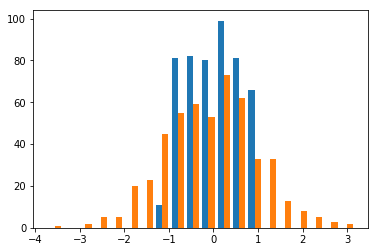

After step 50


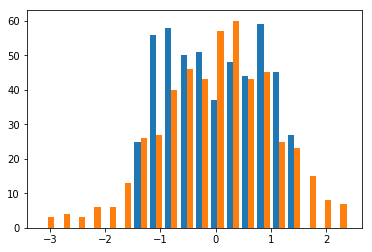

After step 100


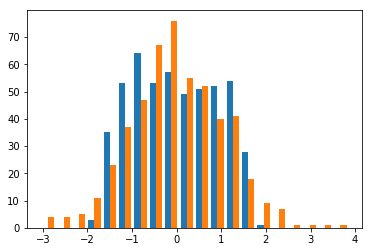

After step 150


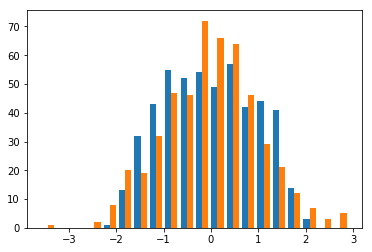

After step 200


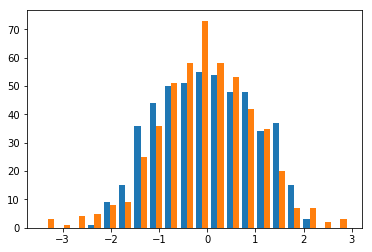

After step 250


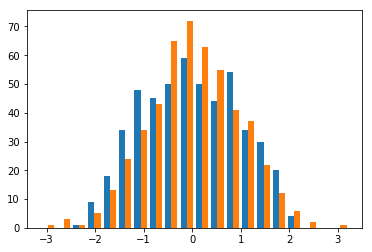

After step 300


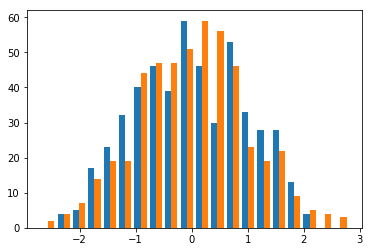

After step 350


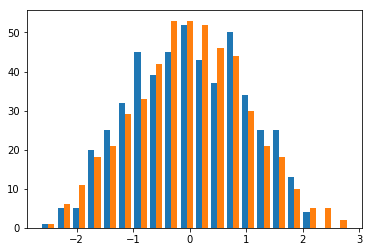

After step 400


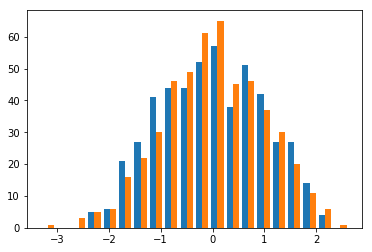

After step 450


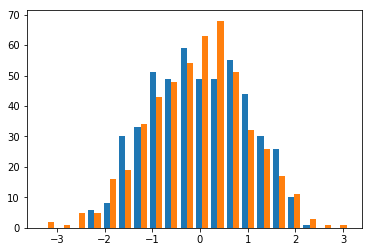

After step 500


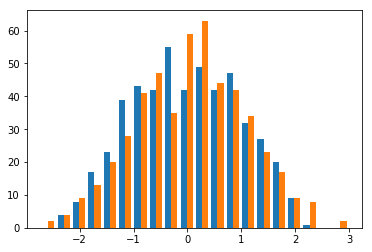

After step 550


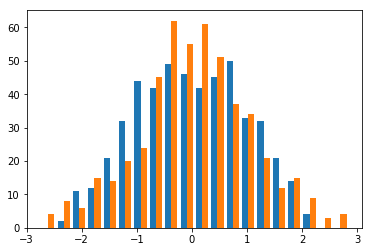

After step 600


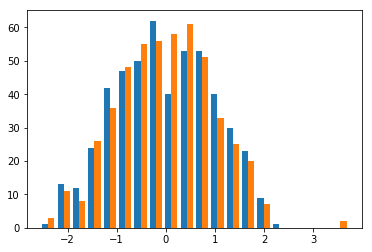

After step 650


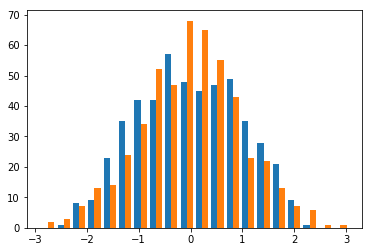

After step 700


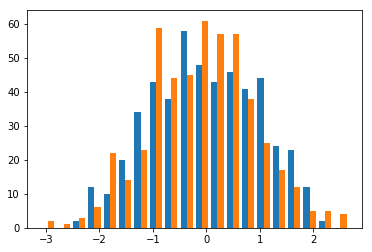

After step 750


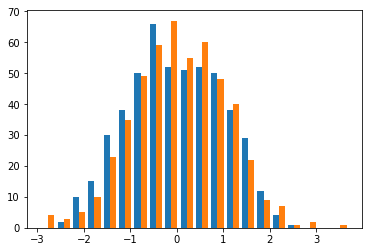

After step 800


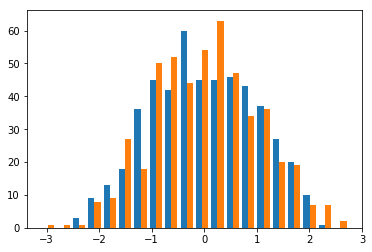

After step 850


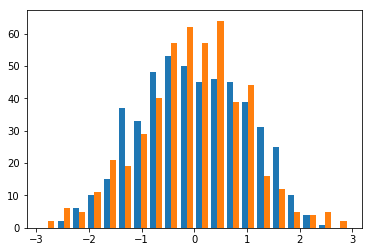

After step 900


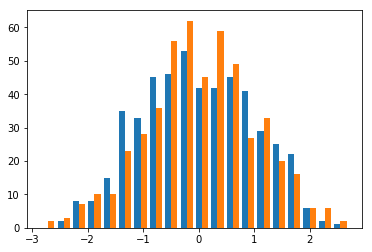

After step 950


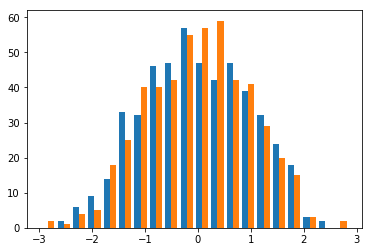

Finally


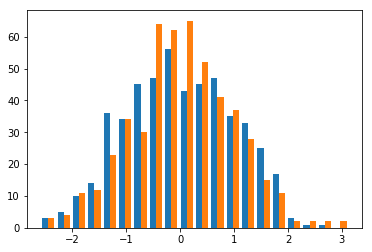

CPU times: user 14min 12s, sys: 1min 28s, total: 15min 41s
Wall time: 3min 59s


In [11]:
%%time

tf.reset_default_graph()

n_samples = 500
n_dims = 100
dist = tfd.MultivariateNormalDiag(
    tf.zeros([n_dims]), tf.ones([n_dims]))
test(n_samples, n_dims, dist, n_iters=1000, vanish_diag=True)

After step 0


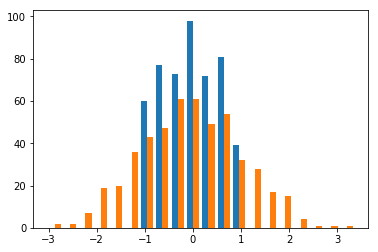

After step 50


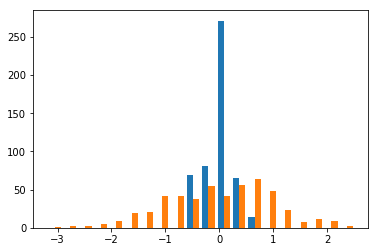

After step 100


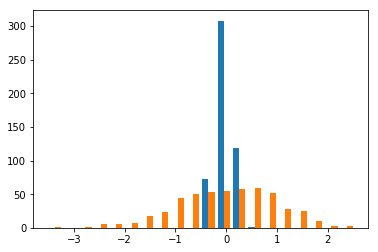

After step 150


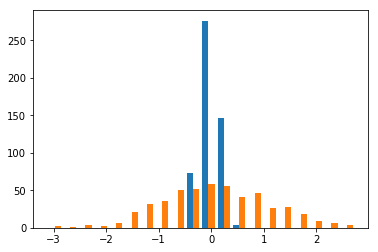

After step 200


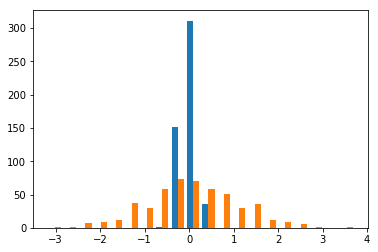

After step 250


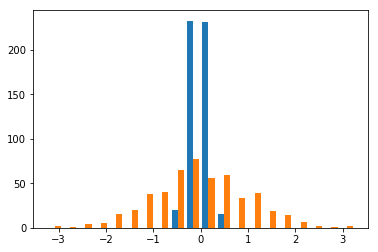

After step 300


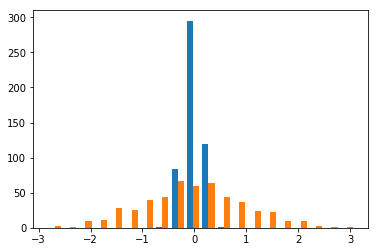

After step 350


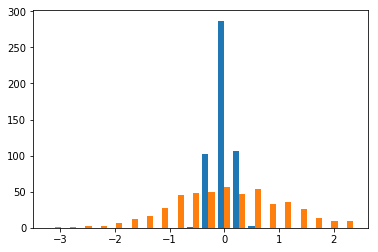

After step 400


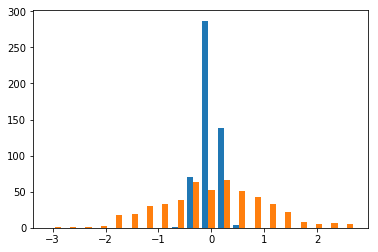

After step 450


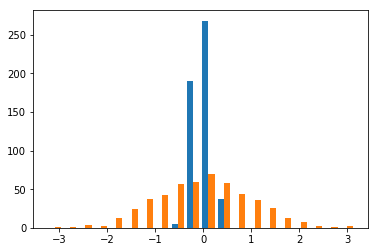

After step 500


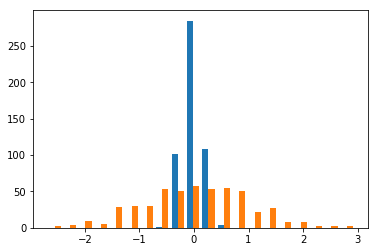

After step 550


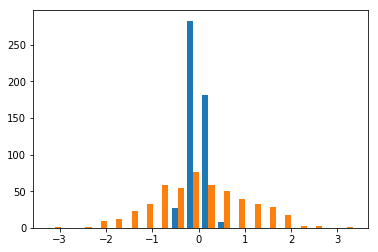

After step 600


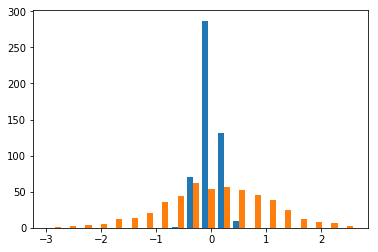

After step 650


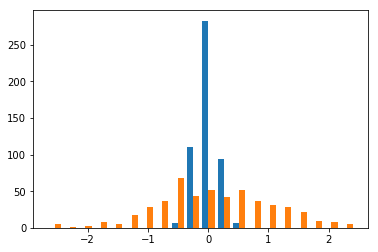

After step 700


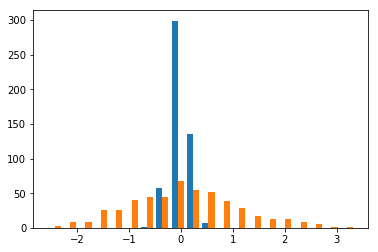

After step 750


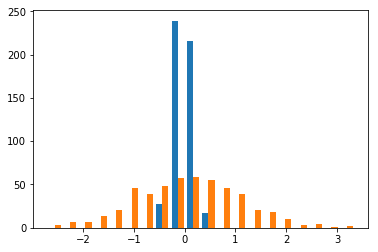

After step 800


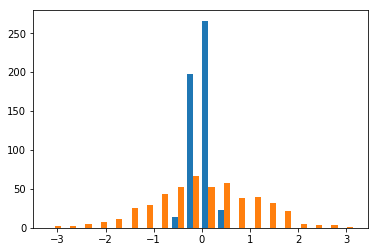

After step 850


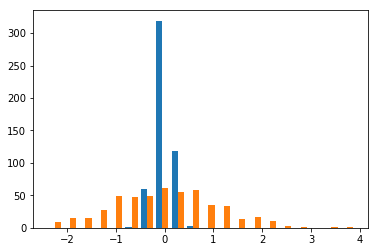

After step 900


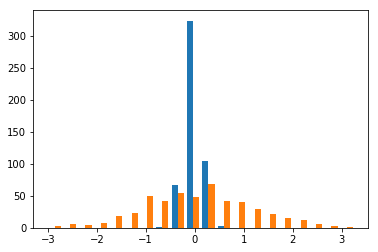

After step 950


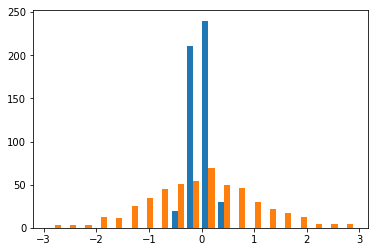

Finally


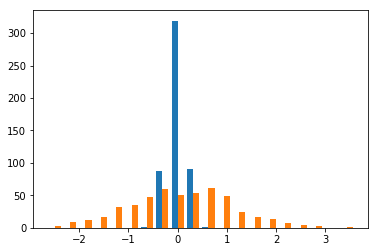

CPU times: user 13min 51s, sys: 1min 25s, total: 15min 16s
Wall time: 3min 47s


In [8]:
%%time

tf.reset_default_graph()

n_samples = 500
n_dims = 100
dist = tfd.MultivariateNormalDiag(
    tf.zeros([n_dims]), tf.ones([n_dims]))
test(n_samples, n_dims, dist, n_iters=1000, vanish_diag=False)

After step 0


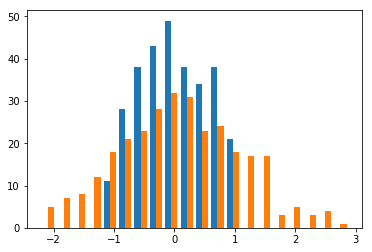

After step 50


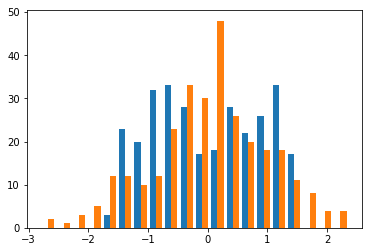

After step 100


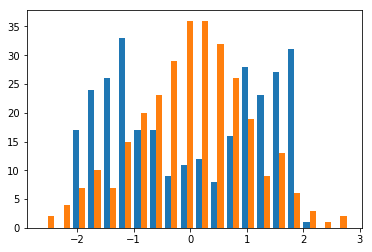

After step 150


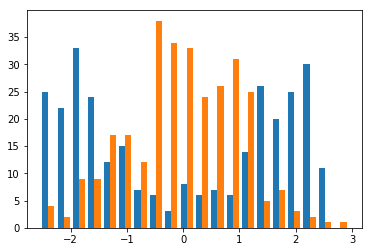

After step 200


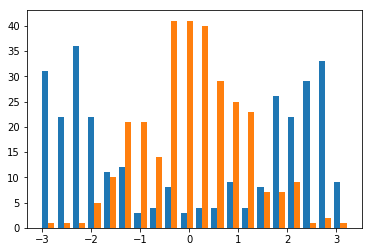

After step 250


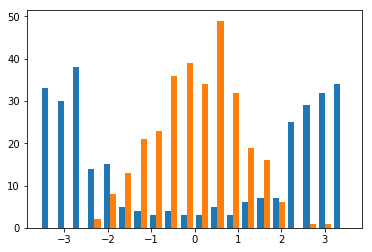

Finally


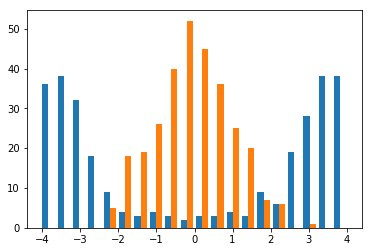

CPU times: user 2min 36s, sys: 16 s, total: 2min 52s
Wall time: 49.1 s


In [20]:
%%time

tf.reset_default_graph()

n_samples = 300
n_dims = 500
dist = tfd.MultivariateNormalDiag(
    tf.zeros([n_dims]), tf.ones([n_dims]))
test(n_samples, n_dims, dist, n_iters=300, vanish_diag=True)

After step 0


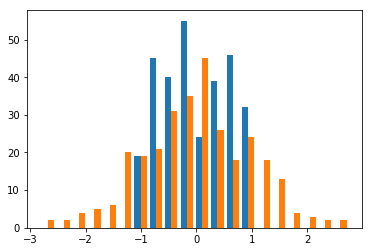

After step 50


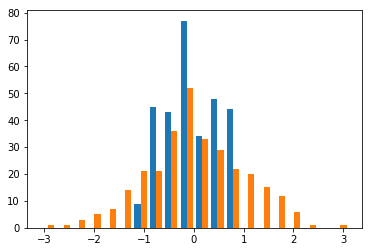

After step 100


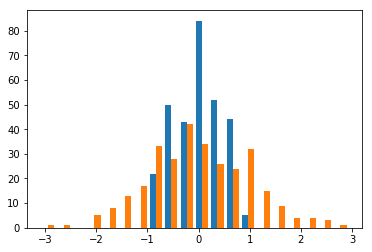

After step 150


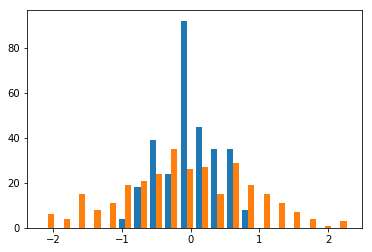

After step 200


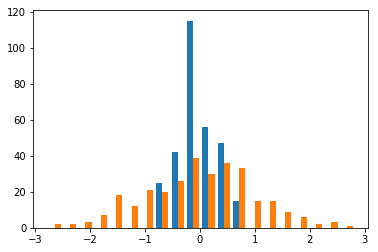

After step 250


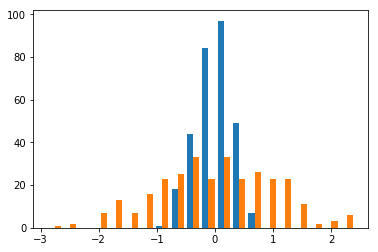

After step 300


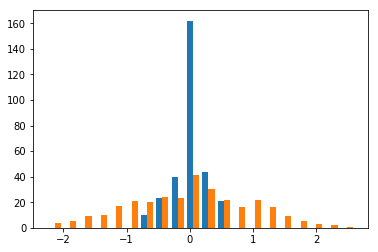

After step 350


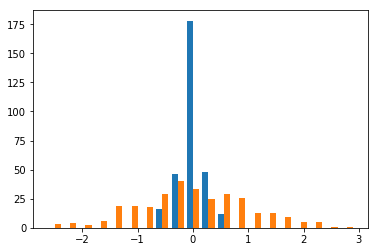

After step 400


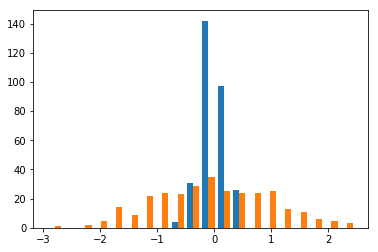

After step 450


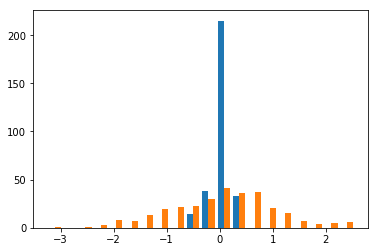

After step 500


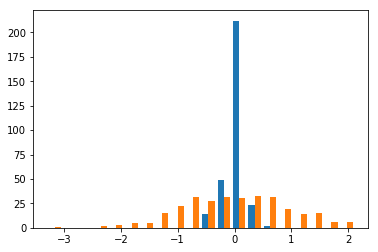

After step 550


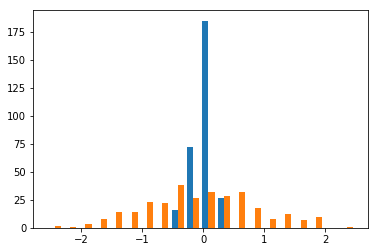

After step 600


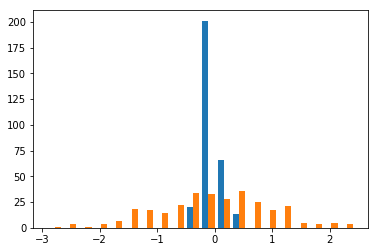

After step 650


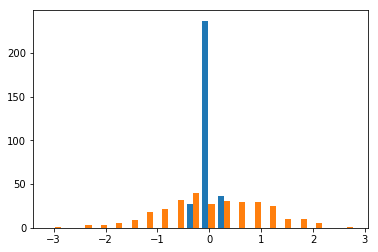

After step 700


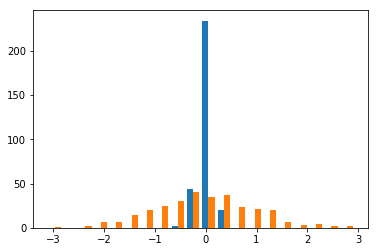

After step 750


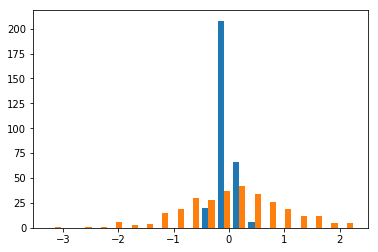

After step 800


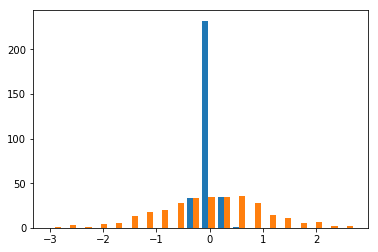

After step 850


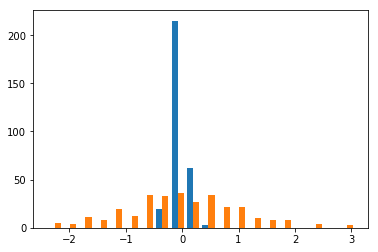

After step 900


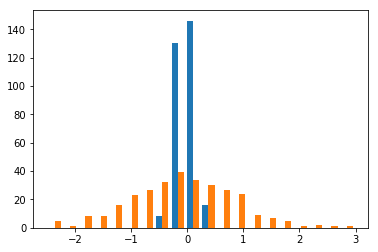

After step 950


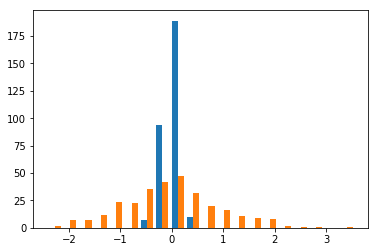

Finally


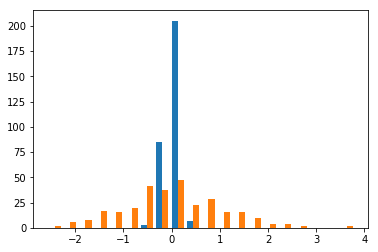

CPU times: user 9min 41s, sys: 55.7 s, total: 10min 36s
Wall time: 3min 50s


In [22]:
%%time

tf.reset_default_graph()

n_samples = 300
n_dims = 500
dist = tfd.MultivariateNormalDiag(
    tf.zeros([n_dims]), tf.ones([n_dims]))
test(n_samples, n_dims, dist, n_iters=1000, vanish_diag=False,
     n_subsamples=20)

After step 0


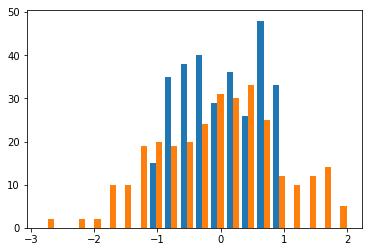

After step 50


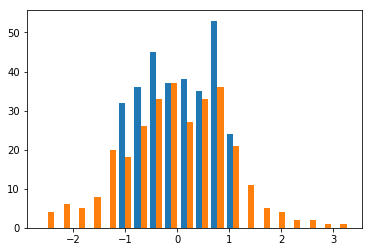

After step 100


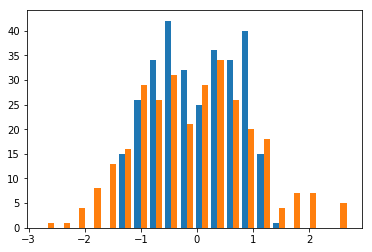

After step 150


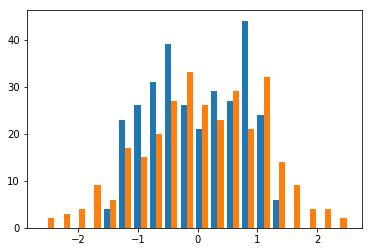

After step 200


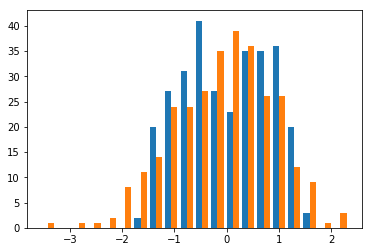

After step 250


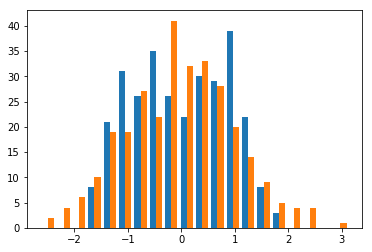

After step 300


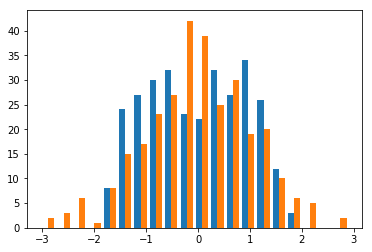

After step 350


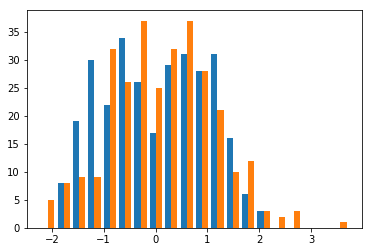

After step 400


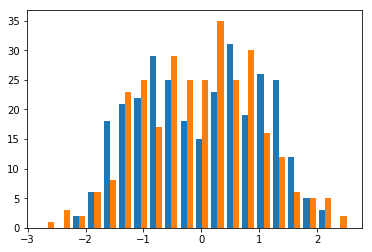

After step 450


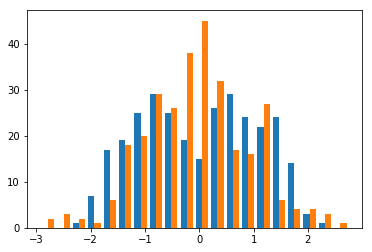

After step 500


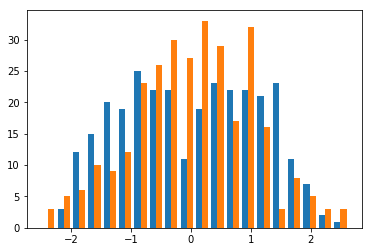

After step 550


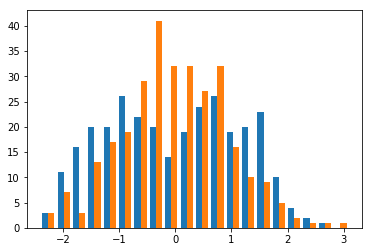

After step 600


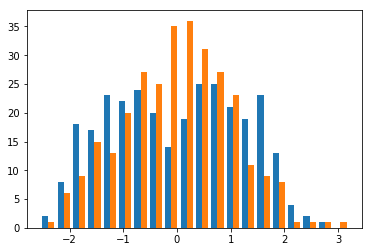

After step 650


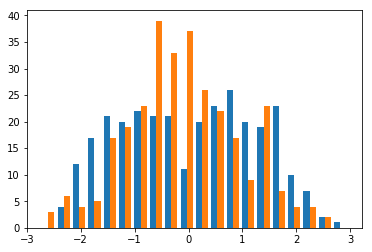

After step 700


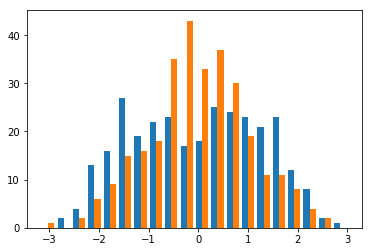

After step 750


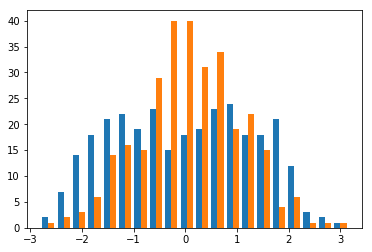

After step 800


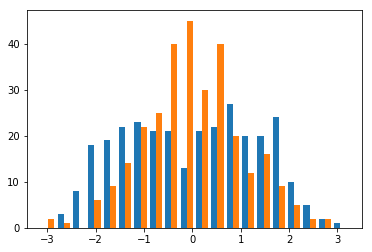

After step 850


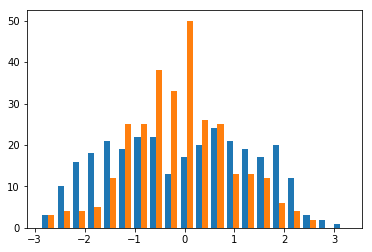

After step 900


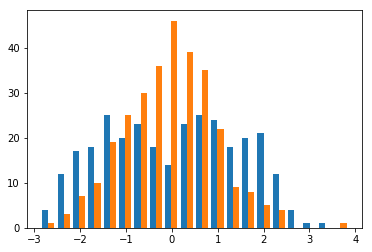

After step 950


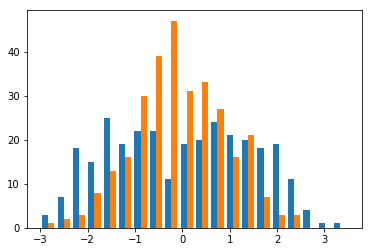

Finally


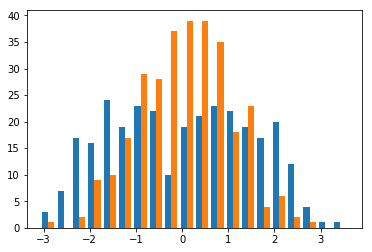

CPU times: user 9min 32s, sys: 54.7 s, total: 10min 26s
Wall time: 3min 56s


In [24]:
%%time

tf.reset_default_graph()

n_samples = 300
n_dims = 500
dist = tfd.MultivariateNormalDiag(
    tf.zeros([n_dims]), tf.ones([n_dims]))
test(n_samples, n_dims, dist, n_iters=1000, vanish_diag=True,
     n_subsamples=100)

After step 0


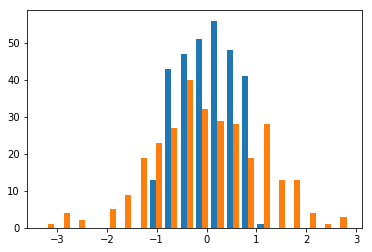

After step 50


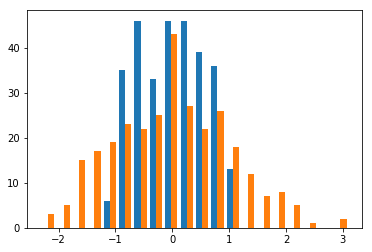

After step 100


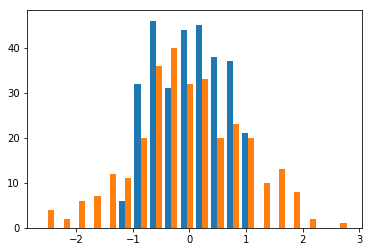

After step 150


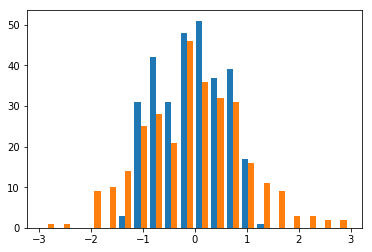

After step 200


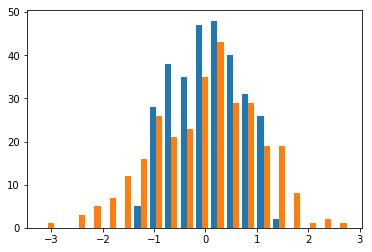

After step 250


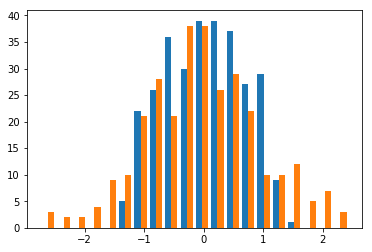

After step 300


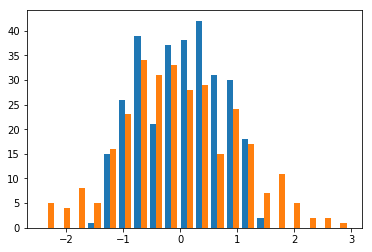

After step 350


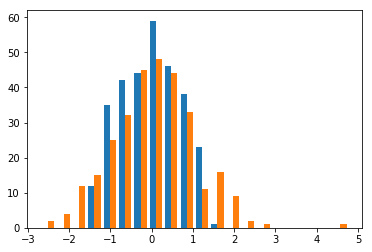

After step 400


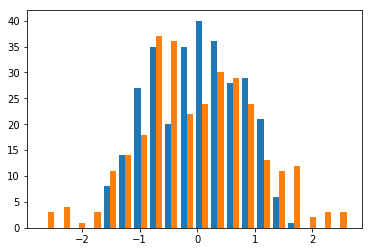

After step 450


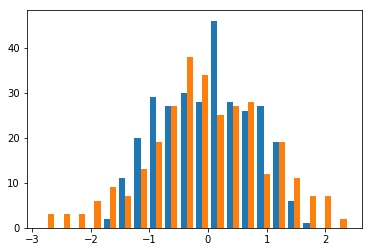

After step 500


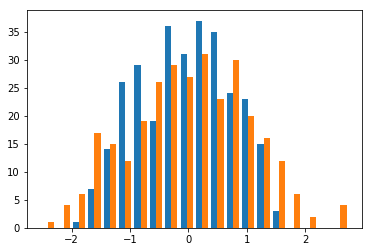

After step 550


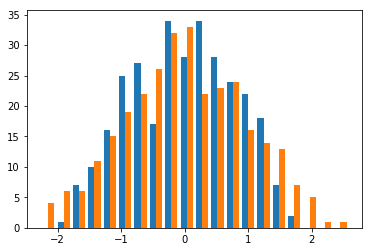

After step 600


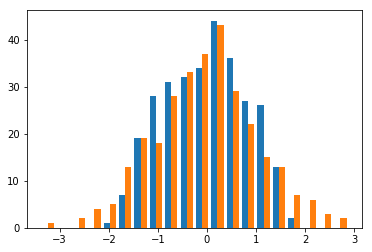

After step 650


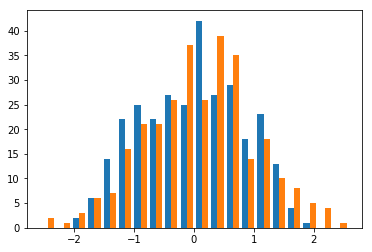

After step 700


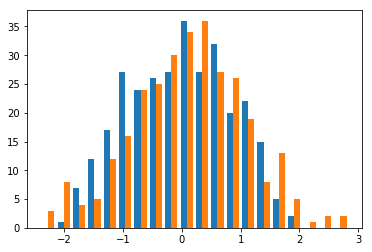

After step 750


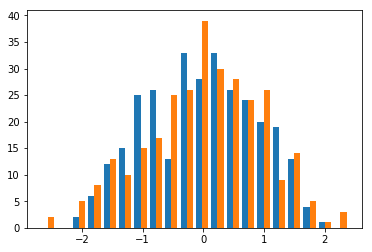

After step 800


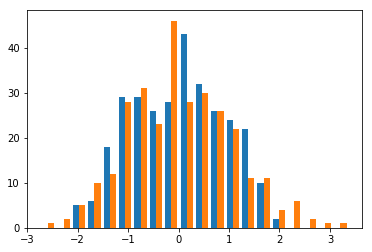

After step 850


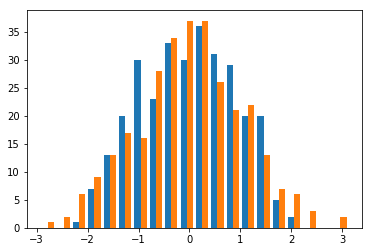

After step 900


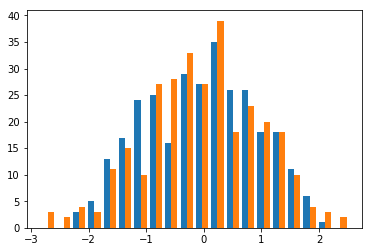

After step 950


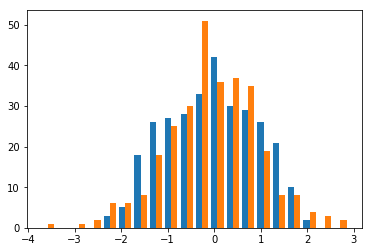

Finally


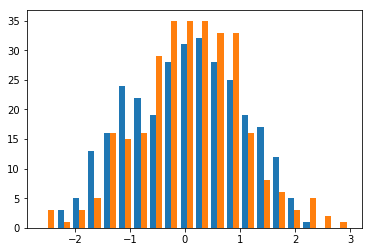

CPU times: user 9min 42s, sys: 55.9 s, total: 10min 38s
Wall time: 3min 58s


In [23]:
%%time

tf.reset_default_graph()

n_samples = 300
n_dims = 500
dist = tfd.MultivariateNormalDiag(
    tf.zeros([n_dims]), tf.ones([n_dims]))
test(n_samples, n_dims, dist, n_iters=1000, vanish_diag=True,
     n_subsamples=20)

In [31]:
def linear_kernel(xs, ys):
  m, n = xs.get_shape().as_list()
  print(m, n)
  # shape `[m, m, n]`
  pairwise = tf.multiply(
      tf.expand_dims(xs, axis=1),
      tf.expand_dims(ys, axis=0))
  kxy = tf.reduce_sum(pairwise, axis=-1)
  grad_kxy_by_x = tf_repeat(tf.expand_dims(ys, axis=0),
                            [m, m, n])
  print(grad_kxy_by_x.shape)
  return kxy, grad_kxy_by_x
    
def tf_repeat(tensor, repeats):
    """https://github.com/tensorflow/tensorflow/issues/8246#issuecomment-337257557
    Args:
      input: A Tensor. 1-D or higher.
      repeats: A list. Number of repeat for each dimension,
        length must be the same as the number of dimensions in input

    Returns:
      A Tensor. Has the same type as input. Has the shape of
      tensor.shape * repeats
    """
    with tf.variable_scope("repeat"):
        expanded_tensor = tf.expand_dims(tensor, -1)
        multiples = [1] + repeats
        tiled_tensor = tf.tile(expanded_tensor, multiples = multiples)
        repeated_tesnor = tf.reshape(tiled_tensor,
                                     tf.shape(tensor) * repeats)
    return repeated_tesnor

In [32]:
%%time

tf.reset_default_graph()

n_samples = 300
n_dims = 500
dist = tfd.MultivariateNormalDiag(
    tf.zeros([n_dims]), tf.ones([n_dims]))
test(n_samples, n_dims, dist, n_iters=1000, vanish_diag=False,
     n_subsamples=20, kernel=linear_kernel)

300 500
(?, ?, ?)


ResourceExhaustedError: OOM when allocating tensor with shape[1,90000,150000,500]
	 [[Node: repeat/Tile = Tile[T=DT_FLOAT, Tmultiples=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](repeat/ExpandDims, repeat/Tile/multiples)]]
	 [[Node: PhiStars/add/_71 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_330_PhiStars/add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'repeat/Tile', defined at:
  File "/home/apps/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/apps/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/apps/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/apps/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/apps/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/apps/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/apps/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/apps/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/apps/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/apps/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/apps/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/apps/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/apps/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/apps/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/apps/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/apps/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/apps/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/apps/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/apps/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2856, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/apps/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-e4c98c36b859>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', '\ntf.reset_default_graph()\n\nn_samples = 300\nn_dims = 500\ndist = tfd.MultivariateNormalDiag(\n    tf.zeros([n_dims]), tf.ones([n_dims]))\ntest(n_samples, n_dims, dist, n_iters=1000, vanish_diag=False,\n     n_subsamples=20, kernel=linear_kernel)')
  File "/home/apps/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2131, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "<decorator-gen-62>", line 2, in time
  File "/home/apps/anaconda3/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/apps/anaconda3/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1238, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 9, in <module>
  File "<ipython-input-27-bd122aed2c4b>", line 8, in test
    vanish_diag, n_subsamples)
  File "<ipython-input-13-23ecbff4c23f>", line 39, in get_phi_stars
    ks, grad_ks = kernel(samples, samples)
  File "<ipython-input-31-dd54dd8f4c50>", line 10, in linear_kernel
    [m, m, n])
  File "<ipython-input-31-dd54dd8f4c50>", line 28, in tf_repeat
    tiled_tensor = tf.tile(expanded_tensor, multiples = multiples)
  File "/home/apps/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5621, in tile
    "Tile", input=input, multiples=multiples, name=name)
  File "/home/apps/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/apps/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/apps/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1,90000,150000,500]
	 [[Node: repeat/Tile = Tile[T=DT_FLOAT, Tmultiples=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](repeat/ExpandDims, repeat/Tile/multiples)]]
	 [[Node: PhiStars/add/_71 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_330_PhiStars/add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
